In [1]:
import optuna
from xgboost import XGBClassifier
import pandas as pd
from sklearn.metrics import roc_auc_score, classification_report, f1_score
import shap
import matplotlib.pyplot as plt
import json

c:\Users\frend\Projects\Classification\hospital_readmission_prediction\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = pd.read_csv("../data/interim/train.csv")
test = pd.read_csv("../data/interim/test.csv")
train.head()

,peserta.STD(fkrtl.lama_hari_kunjungan),peserta.SUM(fkrtl.jml_kunjungan_fkrtl),jml_kunjungan_fkrtl,status_pulang_peserta,MONTH(tanggal_pulang),YEAR(tanggal_pulang),peserta.SUM(fkrtl.lama_hari_kunjungan),peserta.status_peserta,peserta.SUM(fktp.jarak_hari_antar_kunjungan),MONTH(tanggal_datang),...,peserta.MAX(fktp.jarak_hari_antar_kunjungan),peserta.SUM(fkrtl.no_keluarga),peserta.MIN(fkrtl.spesifikasi_kelompok_kasus),peserta.SUM(fkrtl.bobot),peserta.STD(fkrtl.biaya_tagih),peserta.SUM(fktp.bobot),peserta.MIN(fkrtl.biaya_tagih),peserta.gender,peserta.COUNT(fktp),readmitted_30d
0,0.227699,-0.094196,0.864951,0,4,2020,0.268705,2,-1.721583,4,...,0.000000,-0.356290,-0.504986,0.542504,-0.589181,-0.762970,-1.170089,1,-0.876887,0
1,-0.298560,-0.225341,-0.489105,3,0,2020,-0.192478,2,-1.721583,0,...,0.000000,-0.346450,-0.823839,-0.005455,-0.906346,-0.671221,-0.605438,1,-0.784533,1
2,0.020066,-0.094196,0.187923,3,7,2020,0.360941,1,0.433170,7,...,-0.478321,-0.172754,-0.823839,0.495776,-0.355748,1.089862,-0.454042,0,0.970200,0
3,-0.422445,1.086116,2.896035,3,11,2020,1.652253,1,0.860893,11,...,-0.001438,-0.091115,-0.504986,2.748588,-0.092010,0.541366,-1.153514,1,0.323719,1
4,-0.313880,4.823769,3.573063,3,3,2020,1.560016,2,-1.140526,3,...,-0.250247,0.746741,-0.823839,4.267781,-0.224923,-0.610887,-0.894251,1,-0.692178,1


In [3]:
X_train = train.drop(columns=['readmitted_30d'])
y_train = train[['readmitted_30d']]
X_test = test.drop(columns=['readmitted_30d'])
y_test = test[['readmitted_30d']]

In [4]:
def objective(trial):
    # Define hyperparameter search space
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0),
    }
    
    model = XGBClassifier(**params, random_state=42)
    model.fit(X_train, y_train)
    # preds = model.predict_proba(X_test)[:, 1]
    # auc = roc_auc_score(y_test, preds)
    y_pred = model.predict(X_test)
    macro_f1 = f1_score(y_test, y_pred, average="macro")
    
    return macro_f1

# Run optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print(f"Best Macro: {study.best_value}")
print(f"Best params: {study.best_params}")

# Visualize optimization
fig = optuna.visualization.plot_optimization_history(study)
fig.write_html("../reports/optimization_history.html")

[I 2026-02-18 15:42:09,741] A new study created in memory with name: no-name-e801baa6-13de-40e4-a993-f301159e655f
[I 2026-02-18 15:42:10,931] Trial 0 finished with value: 0.780461852342923 and parameters: {'max_depth': 5, 'learning_rate': 0.07515201295561705, 'n_estimators': 789, 'min_child_weight': 3, 'gamma': 0.43469322467851257, 'subsample': 0.7798552137937461, 'colsample_bytree': 0.7033628777185381, 'reg_alpha': 0.5109028215759461, 'reg_lambda': 0.14353362726182695}. Best is trial 0 with value: 0.780461852342923.
[I 2026-02-18 15:42:11,881] Trial 1 finished with value: 0.7771626297577854 and parameters: {'max_depth': 8, 'learning_rate': 0.03124935662511648, 'n_estimators': 443, 'min_child_weight': 7, 'gamma': 0.2636628910609353, 'subsample': 0.7843063650032407, 'colsample_bytree': 0.6642028390294742, 'reg_alpha': 0.12466653992358279, 'reg_lambda': 0.41098214208017947}. Best is trial 0 with value: 0.780461852342923.
[I 2026-02-18 15:42:12,999] Trial 2 finished with value: 0.77351040

Best Macro: 0.7901041027927536
Best params: {'max_depth': 5, 'learning_rate': 0.19938076268143845, 'n_estimators': 852, 'min_child_weight': 4, 'gamma': 0.45991504731344807, 'subsample': 0.9712843663363235, 'colsample_bytree': 0.9198254584974369, 'reg_alpha': 0.409069052705838, 'reg_lambda': 0.9827834053073584}


In [5]:
best_params = study.best_params

In [6]:
with open("../artifacts/best_params.json","w") as f:
    json.dump(best_params, f)

In [7]:
# best_params = {
#     'max_depth': 10, 'learning_rate': 0.05365800628422626, 'n_estimators': 999, 'min_child_weight': 7, 'gamma': 0.28747351722204834, 'subsample': 0.9991422863046721, 'colsample_bytree': 0.8999571944439837, 'reg_alpha': 0.901760240095149, 'reg_lambda': 0.954334719585773
# }

In [8]:
with open("../artifacts/best_params.json","r") as f:
    best_params = json.load(f)

In [9]:
model = XGBClassifier(**best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [10]:
preds = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, preds)
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", auc)

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      4716
           1       0.64      0.60      0.62       850

    accuracy                           0.89      5566
   macro avg       0.78      0.77      0.78      5566
weighted avg       0.88      0.89      0.89      5566

ROC AUC Score: 0.937357182058574


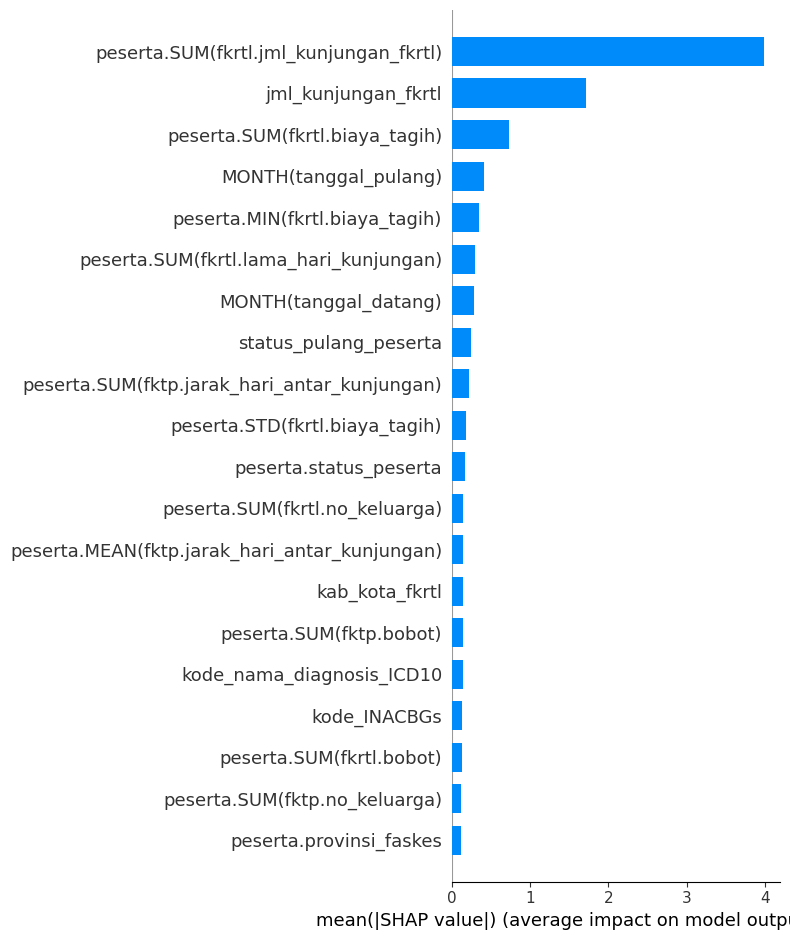

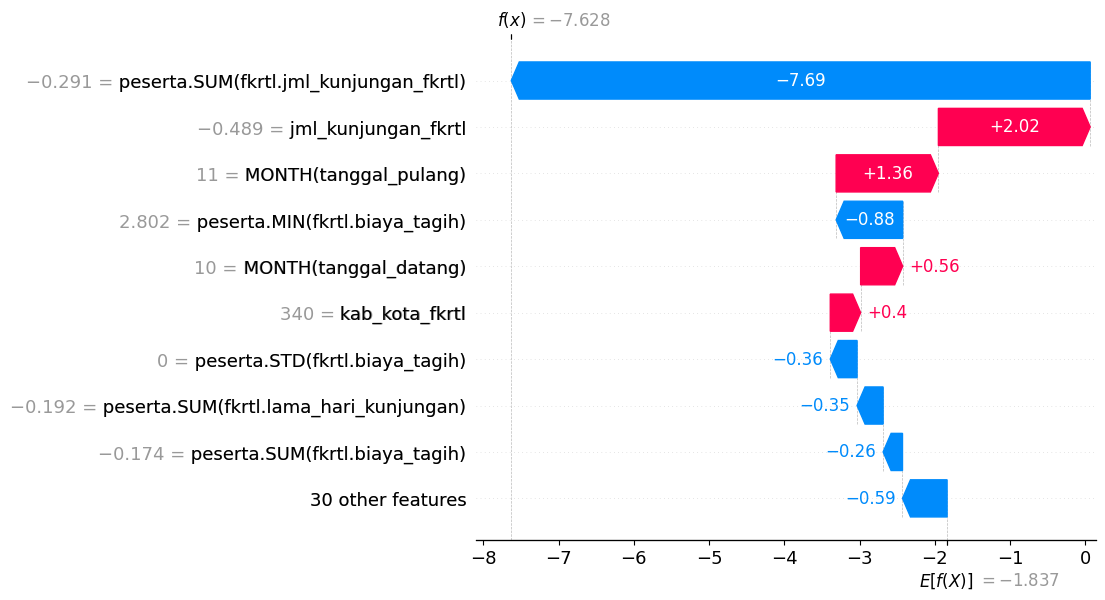

In [11]:
explainer = shap.TreeExplainer(model)
X_test_sample = X_test.sample(n=100, random_state=42)
shap_values = explainer.shap_values(X_test_sample)

shap.summary_plot(shap_values, X_test_sample, plot_type="bar")
plt.savefig("../reports/shap_importance.png")

shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[0],
        base_values=explainer.expected_value,
        data=X_test_sample.iloc[0]
    )
)

force_plot = shap.force_plot(
    explainer.expected_value,
    shap_values[0],
    X_test_sample.iloc[0],
    matplotlib=False 
)
shap.save_html("../reports/force_plot.html", force_plot)